# Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».\
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.\
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

Данные: \
5 столбцов
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).``

## Шаг 1. Загрузим библиотеки и данные. Изучим файл.

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from IPython.display import display
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from tqdm.auto import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
pd.options.display.max_columns = 30
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
try:
    data = pd.read_csv('datasets/users_behavior.csv', sep=',')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv', sep=',')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data.sample(10)

,calls,minutes,messages,mb_used,is_ultra
2169,134.00,947.28,67.00,"20,160.96",1
1289,68.00,328.74,13.00,"17,364.33",0
868,109.00,763.22,42.00,"17,236.50",0
2860,87.00,667.18,80.00,"10,683.75",1
2510,63.00,508.70,21.00,"19,254.67",1
1014,96.00,655.52,2.00,"20,432.78",0
838,61.00,452.89,27.00,"10,444.65",0
381,82.00,521.66,30.00,"13,396.91",1
2764,81.00,575.14,4.00,"8,946.73",1
1210,83.00,588.51,0.00,"18,698.90",0


* Нет пропущенных значений.
* Типы данных в порядке.

In [5]:
print('Явных дубликатов:',data.duplicated().sum())

Явных дубликатов: 0


Далее, перед построением моделей, необходимо проверить данные на мультиколлинеарность:
* С помошью матрницы корреляций.
* С помощью VIF - индекса.

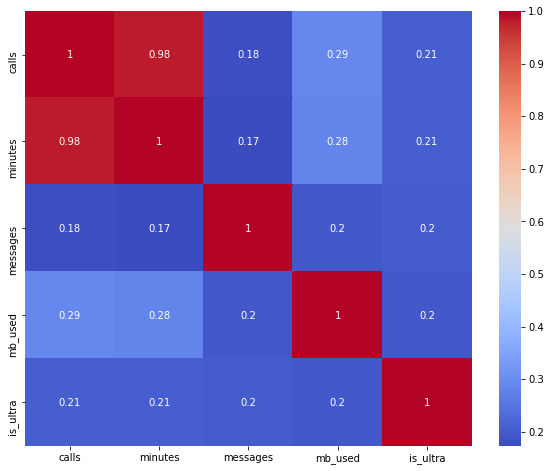

In [6]:
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [7]:
df_const = add_constant(data)

vif = pd.DataFrame()
vif["variables"] = df_const.columns
vif["VIF"] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

print(vif)

  variables   VIF
0     const  8.08
1     calls 28.28
2   minutes 28.17
3  messages  1.08
4   mb_used  1.13
5  is_ultra  1.09


#### Выводы о мультиколлинеарности.

* Коэффициент корреляции между признаками "calls" (количество звонков) и "minutes" (суммарная длительность звонков в минутах) близок к 1, это указывает на очень сильную положительную линейную зависимость между этими двумя признаками. Это означает, что с увеличением количества звонков также увеличивается суммарная длительность звонков в минутах, и наоборот. Данный коэффициент корреляции близкий к 1 может быть хорошей индикацией того, что эти два признака сильно связаны друг с другом и изменяются в схожем направлении.
* VIF - это индекс, который вычисляет, насколько дисперсия оценки коэффициента возрастает, когда ваши предикторы коррелированы. Если VIF больше 10, это обычно указывает на мультиколлинеарность. \
VIF-индекс переменных `calls` и `minutes`- больше 28, что говорит о явной мультиколлинеарности. \
Для создания моделей откинем переменную `minutes`.

### Переменная `is_ultra`
В ходе анализа данных, понял, что необходимо исследовать эту переменную.

In [8]:
count = data['is_ultra'].value_counts()
percentage = data['is_ultra'].value_counts(normalize=True) * 100

print(count)
print(percentage)

0    2229
1     985
Name: is_ultra, dtype: int64
0   69.35
1   30.65
Name: is_ultra, dtype: float64


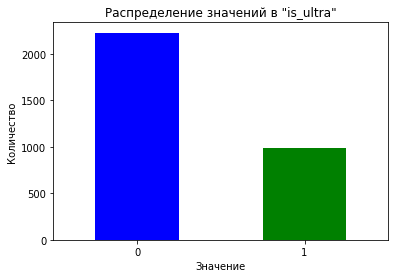

In [9]:
count.plot(kind='bar', color=['blue', 'green'])
plt.title('Распределение значений в "is_ultra"')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.xticks([0,1], ['0', '1'], rotation=0)
plt.show()

Такое существенное расхождение в их численностях следует учитывать при последующем разделении на валидационные и тестовые наборы данных.

### Вывод шага 1

* Пропусков не обнаружено.
* Дубликатов не обнаружено.
* Мы не будем учитывать признак "minutes" в дальнейшем анализе, поскольку он сильно коррелирует с признаком "calls". (По итогам матрицы кор. и VIF-индекса)
* При разделении данных на валидационные и тестовые наборы следим за соотношением между значениями, они должны находиться в пределах от 0 до 1.
* Для сохранения соотношения классов в разбивке, можно использовать функцию train_test_split из библиотеки sklearn с аргументом stratify, который обеспечивает стратификацию при разбивке.

## Шаг 2. Разбейте данные на выборки.

#### Необходимо разделить данные на `features` и выделить ключевой признак - `target`

In [10]:
features = data.drop(['minutes', 'is_ultra'], axis=1) # решение об исключении *minutes* принято ранее
target = data['is_ultra'] 

Наш ключевой признак - `is_ultra`, именно его мы попытаемся "предсказать"

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   messages  3214 non-null   float64
 2   mb_used   3214 non-null   float64
dtypes: float64(3)
memory usage: 75.5 KB


#### Разобъем на тренировочную, тестовую и валидационную выборки.
Сначала разобьем данные на обучающую выборку (60%) и временную выборку (40%). Затем временную выборку разобьем пополам на тестовую и валидационную выборки, таким образом, получим разбивку 60% - 20% - 20%.
* Для сохранения соотношения классов в разбивке, можно использовать функцию `train_test_split` из библиотеки `sklearn` с аргументом `stratify`, который обеспечивает стратификацию при разбивке.

In [12]:
# Разбиение на обучающую выборку и временную выборку
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=42, stratify=target)

# Разбиение временной выборки на тестовую и валидационную выборки
features_test, features_valid, target_test, target_valid = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=42, stratify=target_temp)

# Проверка размеров выборок
print("Изначальный размер:", len(data))
print("Train size:", len(features_train))
print("Test size:", len(features_test))
print("Validation size:", len(features_valid))

Изначальный размер: 3214
Train size: 1928
Test size: 643
Validation size: 643


In [13]:
total_data_count = len(data)
train_percentage = (len(features_train) / total_data_count) * 100
test_percentage = (len(features_test) / total_data_count) * 100
valid_percentage = (len(features_valid) / total_data_count) * 100
print(f"Train size: {len(features_train)} ({train_percentage:.1f}%)")
print(f"Test size: {len(features_test)} ({test_percentage:.1f}%)")
print(f"Validation size: {len(features_valid)} ({valid_percentage:.1f}%)")

Train size: 1928 (60.0%)
Test size: 643 (20.0%)
Validation size: 643 (20.0%)


#### Вывод

* Разбили данные на обучающую выборку (60%) и временную выборку (40%). Затем временную выборку разобили пополам на тестовую и валидационную выборки, таким образом, получим разбивку 60% - 20% - 20%.
* Для сохранения соотношения классов в разбивке, воспользовались аргументом `stratify`, который обеспечивает стратификацию при разбивке.

## Шаг 3

#### Построим модель древа решений, для решения задачи классификации

##### Обучим модель дерева решений на обучающей выборке.
* Предскажим значения на обучающей и валидационной выборках.
* Рассчитаем значение accuracy для обучающей и валидационной выборок.

In [14]:
# 1. Обучение модели дерева решений
model = DecisionTreeClassifier(random_state=123)
model.fit(features_train, target_train)

# 2. Предсказание значений
train_predictions = model.predict(features_train)
valid_predictions = model.predict(features_valid)

# 3. Расчет accuracy
train_accuracy = accuracy_score(target_train, train_predictions)
valid_accuracy = accuracy_score(target_valid, valid_predictions)

print(f"Accuracy on training data: {train_accuracy:.2f}")
print(f"Accuracy on validation data: {valid_accuracy:.2f}")

Accuracy on training data: 1.00
Accuracy on validation data: 0.71


##### Оценим различные значение глубины дерева для нахождения оптимального значения \
Нам следует выполнить следующие действия:
* Создать цикл, в котором будем обучать дерево решений с разными значениями глубины.
* Для каждой глубины оценить `accuracy` на валидационной выборке.
* Выбрать глубину, при которой достигается максимальное значение accuracy.

In [15]:
train_accuracies = []  # список для хранения accuracy на обучающей выборке
valid_accuracies = []  # список для хранения accuracy на валидационной выборке
best_accuracy = 0  # инициализируем переменную для хранения лучшего значения accuracy
best_depth = 0  # инициализируем переменную для хранения оптимальной глубины

for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    
    # Расчет accuracy на обучающей выборке и сохранение в список
    train_predictions = model.predict(features_train)
    train_accuracy = accuracy_score(target_train, train_predictions)
    train_accuracies.append(train_accuracy)
    
    # Расчет accuracy на валидационной выборке и сохранение в список
    valid_predictions = model.predict(features_valid)
    valid_accuracy = accuracy_score(target_valid, valid_predictions)
    valid_accuracies.append(valid_accuracy)
    
    # Выводим текущую глубину и значения accuracy
    print(f"Depth: {depth}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}")
    
    # Если текущая accuracy на валидационной выборке лучше предыдущей лучшей, обновляем значения
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_depth = depth

print(f"\nBest depth: {best_depth} with validation accuracy: {best_accuracy:.4f}")

Depth: 1, Training Accuracy: 0.7510, Validation Accuracy: 0.7496
Depth: 2, Training Accuracy: 0.7837, Validation Accuracy: 0.7698
Depth: 3, Training Accuracy: 0.7956, Validation Accuracy: 0.7807
Depth: 4, Training Accuracy: 0.7972, Validation Accuracy: 0.7807
Depth: 5, Training Accuracy: 0.8154, Validation Accuracy: 0.7900
Depth: 6, Training Accuracy: 0.8294, Validation Accuracy: 0.7838
Depth: 7, Training Accuracy: 0.8418, Validation Accuracy: 0.7932
Depth: 8, Training Accuracy: 0.8506, Validation Accuracy: 0.7947
Depth: 9, Training Accuracy: 0.8620, Validation Accuracy: 0.7932
Depth: 10, Training Accuracy: 0.8786, Validation Accuracy: 0.7869
Depth: 11, Training Accuracy: 0.8926, Validation Accuracy: 0.7745
Depth: 12, Training Accuracy: 0.9087, Validation Accuracy: 0.7667
Depth: 13, Training Accuracy: 0.9243, Validation Accuracy: 0.7683
Depth: 14, Training Accuracy: 0.9372, Validation Accuracy: 0.7636
Depth: 15, Training Accuracy: 0.9523, Validation Accuracy: 0.7449
Depth: 16, Training

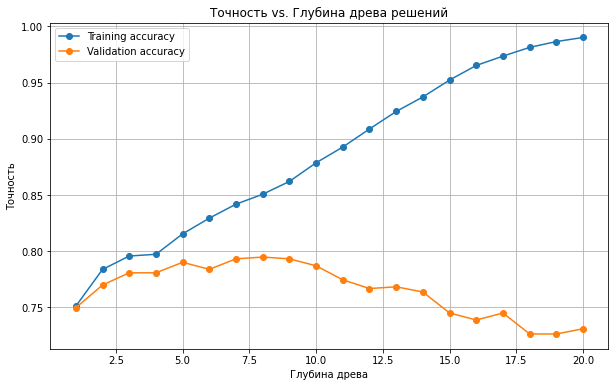

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_accuracies, label='Training accuracy', marker='o')
plt.plot(range(1, 21), valid_accuracies, label='Validation accuracy', marker='o')
plt.xlabel('Глубина древа')
plt.ylabel('Точность')
plt.legend()
plt.title('Точность vs. Глубина древа решений')
plt.grid(True)
plt.show()

Исходя из цикла, а также графика видно, что наилучшее значение глубины древа - 8 дает точность в 0.7947

Давайте посмотрим на наше древо!!\
(Практического смысла от этого не много, мне просто захотелось)

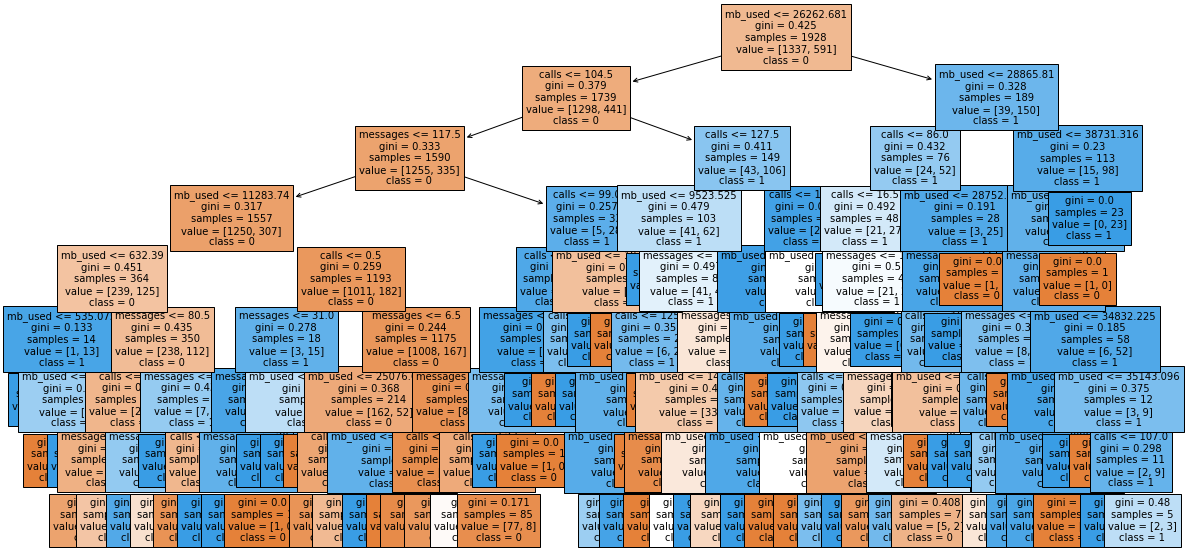

In [36]:
# Обучаем модель дерева решений с оптимальной глубиной (например, 8)
model = DecisionTreeClassifier(max_depth=8)
model.fit(features_train, target_train)
# Визуализация дерева решений
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=features_train.columns, class_names=['0','1'], fontsize=10)
plt.show()

#### Давайте сохраним лучшие параметры и название этой модели, создадим для этого отдельную таблицу

In [18]:
models_summary = pd.DataFrame(columns=['Model', 'Best depth', 'Accuracy', 'n_estimators'])
def add_model_summary(model_name, best_params, accuracy, n_estimators=None):
    global models_summary
    models_summary = models_summary.append({'Model': model_name, 
                                            'Best depth': best_params, 
                                            'Accuracy': accuracy,
                                            'n_estimators': n_estimators}, 
                                           ignore_index=True)

In [19]:
add_model_summary('DecisionTreeClassifier', 8, 0.7947, 0)

In [20]:
print(models_summary)

                    Model Best depth  Accuracy n_estimators
0  DecisionTreeClassifier          8      0.79            0


##### Выводы
* Построили модель DecisionTreeClassifier
   * Наилучшая глубина - 8
   * При такой глубине точность (accuracy) - 0.79
* Создали таблицу, чтобы заносить лучшие параметры разных моделей
* Написали функцию, которая будет добавлять в таблицу лучшие параметры

#### Модель Случайного леса

In [21]:
best_accuracy = 0  # инициализация переменной для лучшей точности
best_depth = 0  # инициализация переменной для лучшей глубины
best_est = 0  # инициализация переменной для лучшего количества деревьев

# Цикл для проверки различного количества деревьев
for est in range(10, 70, 10):  # проверяем от 10 до 100 деревьев с шагом 10
    # Цикл для проверки различной глубины дерева
    for depth in range(1, 21):  # проверяем глубину от 1 до 20
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        valid_predictions = model.predict(features_valid)
        current_accuracy = accuracy_score(target_valid, valid_predictions)
        
        # Если текущая точность лучше предыдущей лучшей, обновляем значения
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_depth = depth
            best_est = est

print(f"\nBest number of estimators: {best_est}, Best depth: {best_depth} with accuracy: {best_accuracy:.4f}")

# Сохраняем информацию о лучшей модели в нашу таблицу



Best number of estimators: 30, Best depth: 10 with accuracy: 0.8149


In [22]:
add_model_summary('RandomForestClassifier', best_depth, best_accuracy, best_est)

График зависимости качества модели "случайный лес" от глубины дерева и количества деревьев может быть полезным, но его построение и интерпретация немного сложнее, чем для одной переменной, такой как глубина дерева для модели "дерево решений". \
Построение такого графика может быть визуально сложным из-за двух изменяющихся параметров. Один из способов визуализации - это использование тепловой карты, где одна ось представляет глубину дерева, другая ось представляет количество деревьев, а цвет ячейки показывает качество модели.

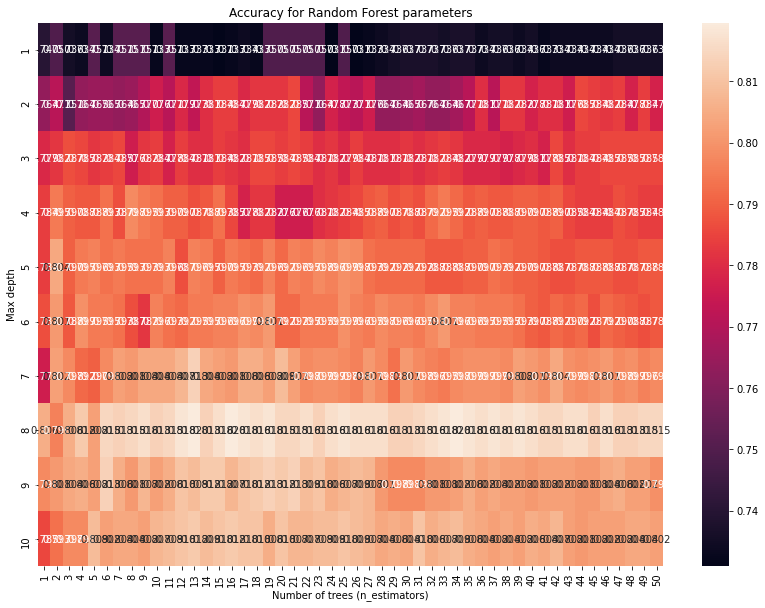

In [23]:
max_depth_values = range(1, 11)
n_estimators_values = range(1, 51)
results = np.zeros((len(max_depth_values), len(n_estimators_values)))

for i, depth in enumerate(max_depth_values):
    for j, n_estimators in enumerate(n_estimators_values):
        model = RandomForestClassifier(max_depth=depth, n_estimators=n_estimators, random_state=123)
        model.fit(features_train, target_train)
        valid_predictions = model.predict(features_valid)
        results[i, j] = accuracy_score(target_valid, valid_predictions)

# Создание тепловой карты
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(results, annot=True, fmt=".3f", xticklabels=n_estimators_values, yticklabels=max_depth_values)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.xlabel('Number of trees (n_estimators)')
plt.ylabel('Max depth')
plt.title('Accuracy for Random Forest parameters')
plt.show()

В целом, матрица дает представление о том, что лучшая глубина дерева - 8, однко ее создание сильно ресурсозатраное. \
(ПОМЕТКА ДЛЯ ПРОВЕРЯЮЩЕГО - Я МОГУ УДАЛИТЬ ГРАФИК. ВЫШЕ ЦИКЛ НАШЕЛ НАИЛУЧШУЮ ГЛУБИНУ И ЗАПИСАЛ ЕЕ В ТАБЛИЦУ, ВИЗУАЛИЗАЦИЯ ТАК ПОНИМАЮ - НЕ ОБЯЗАТЕЛЬНА. ТК ДЕЛАЛ РАБОТУ ЛОКАЛЬНО И МОЙ ПК СПРАВЛЯЕТСЯ С ЗАДАЧЕЙ ЗА 5.3 СЕК, НЕ ЗНАЮ СКОЛЬКО ЭТО ПОТРЕБУЕТ ВРЕМЕНИ ДЛЯ РАСЧЕТА СЕРВЕРОМ)

#### Классификация с помощью модели `логистическая регрессия`.

In [24]:
logreg_model = LogisticRegression(random_state=12345, solver='liblinear')

# Обучение модели на обучающей выборке
logreg_model.fit(features_train, target_train)

# Предсказание на валидационной выборке
valid_predictions = logreg_model.predict(features_valid)

# Расчет accuracy на валидационной выборке
valid_accuracy = accuracy_score(target_valid, valid_predictions)

print(f"Accuracy on validation data: {valid_accuracy:.4f}")

Accuracy on validation data: 0.7076


In [25]:
add_model_summary('LogisticRegression', 'Default', valid_accuracy, 0)

In [26]:
print(models_summary)

                    Model Best depth  Accuracy n_estimators
0  DecisionTreeClassifier          8      0.79            0
1  RandomForestClassifier         10      0.81           30
2      LogisticRegression    Default      0.71            0


#### Модель k-ближайших соседей (k-Nearest Neighbors, k-NN)

Рассмотрим k-ближайших соседей (k-Nearest Neighbors, k-NN). Это простой метод, который классифицирует объекты на основе расстояния до ближайших обучающих примеров. 

Основной параметр для k-NN — это k, который представляет количество соседей, используемых для классификации. Другие параметры включают выбор функции расстояния (например, евклидово, манхэттенское и т. д.), но по умолчанию обычно используется евклидово расстояние.

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=3)

# Обучаем модель
knn_model.fit(features_train, target_train)

# Предсказываем на валидационной выборке
knn_predictions = knn_model.predict(features_valid)

# Вычисляем accuracy
knn_accuracy = accuracy_score(target_valid, knn_predictions)
print(f"Accuracy of k-NN model with 3 neighbors: {knn_accuracy:.4f}")

Accuracy of k-NN model with 3 neighbors: 0.7325


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [28]:
add_model_summary('KNeighborsClassifier', 'Default', knn_accuracy, 0)

In [29]:
print(models_summary.sort_values(by='Accuracy', ascending=False))

                    Model Best depth  Accuracy n_estimators
1  RandomForestClassifier         10      0.81           30
0  DecisionTreeClassifier          8      0.79            0
3    KNeighborsClassifier    Default      0.73            0
2      LogisticRegression    Default      0.71            0


#### Выводы
* Точность на модели логистической регрессии и модели k-соседей примерно одинаковая ~ 0.73
* Вторая по точности модель - `DecisionTreeClassifier` с *accuracy* - 0.79 при глубине 8
* Лучшая модель классификации `RandomForestClassifier` c *accuracy* - 0.81 при глубине 10 и кол-ве деревьев 30
* Далее проверим лучшую модель на тестовой выборке, также запишем результаты.

## Шаг 4. Проверим лучшую модель на тестовой выборке.

In [30]:
model = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=12345)

# Обучаем модель на обучающей выборке
model.fit(features_train, target_train)

# Производим предсказания на тестовой выборке
test_predictions = model.predict(features_test)

# Вычисляем метрику accuracy на тестовой выборке
test_accuracy = accuracy_score(target_test, test_predictions)

print(f"Accuracy на тестовой выборке: {test_accuracy:.4f}")

Accuracy на тестовой выборке: 0.7994


Добавим результат в таблицу

In [31]:
add_model_summary('RandomForest_TEST', 10, test_accuracy, 30)

In [32]:
print(models_summary.sort_values(by='Accuracy', ascending=False))

                    Model Best depth  Accuracy n_estimators
1  RandomForestClassifier         10      0.81           30
4       RandomForest_TEST         10      0.80           30
0  DecisionTreeClassifier          8      0.79            0
3    KNeighborsClassifier    Default      0.73            0
2      LogisticRegression    Default      0.71            0


#### Вывод
* На тестовой выборке модель показала результат с точностью в 0.7994 при глубине 10 и кол-ве деревьев 30
* Необходимо проверить модель на адекватность
* Accuracy > 0.75 (требование по условию) на моделях:
   * DecisionTreeClassifier - 0.7947
   * RandomForestClassifier - 0.8149300156
   * RandomForestClassifier на тестовой выборке - 0.799377916
* Accuracy < 0.75 (требование по условию) на моделях:
   * LogisticRegression - 0.734059098
   * KNeighborsClassifier - 0.732503888

#### Проверим модель на адекватность с помощью `DummyClassifier`

In [33]:
# Создаем Dummy модель
dummy_model = DummyClassifier(strategy="most_frequent")
# Обучаем модель
dummy_model.fit(features_train, target_train)
# Производим предсказания на тестовой выборке
dummy_predictions = dummy_model.predict(features_test)
# Вычисляем метрику accuracy для dummy модели
dummy_accuracy = accuracy_score(target_test, dummy_predictions)
print(f"Accuracy Dummy модели на тестовой выборке: {dummy_accuracy:.4f}")

Accuracy Dummy модели на тестовой выборке: 0.6936


In [34]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(features_train, target_train)
dummy_valid_predictions = dummy_model.predict(features_valid)
dummy_valid_accuracy = accuracy_score(target_valid, dummy_valid_predictions)
print(f"Accuracy Dummy модели на валидационной выборке: {dummy_valid_accuracy:.4f}")

Accuracy Dummy модели на валидационной выборке: 0.6936


In [35]:
add_model_summary('DummyClassifier',0, dummy_accuracy, 0)

#### Вывод

Если наша основная модель (в вашем случае RandomForestClassifier) показывает результаты лучше, чем `DummyClassifier`, это говорит о том, что ваша модель работает адекватно. Если результаты похожи или хуже, это может указывать на проблемы в вашей основной модели.
Таким образом значения accuracy модели `DummyClassifier` - 0.6936 ниже чем точность лучшей модели - таким образом, наша модель адекватна.

## Шаг 5 Общий вывод

* Мы провели исследование с целью разработать модель, которая сможет наилучшим образом предложить пользователям мобильной связи тарифы "Смарт" или "Ультра".

* Модель создана на основе данных о поведении клиентов, которые уже перешли на эти тарифы.

* В рамках исследования мы разработали три различные модели: "Дерево решений" (Decision Tree Classifier), "Случайный лес" (RandomForestClassifier), "Логистическая регрессия" (Logistic Regression), а также k-ближайших соседей (k-Nearest Neighbors, k-NN).

* После сравнения моделей, мы выбрали наилучшей "Случайный лес" с определенными гиперпараметрами, такими как n_estimators=30 и max_depth=10. Эта модель показала точность (accuracy) равную 0.814 на валид выборке.

* Важно отметить, что лучшие модели соответствуют установленным требованиям по качеству, которые предполагают, что значение точности (accuracy) не должно быть менее 0.75.

* Лучшая модель была протестирована на наборе данных, который не использовался в обучении и валидации. Здесь значение точности составило 0.799.

* Для проверки адекватности выбранной модели "Случайный лес" мы также использовали модель DummyClassifier, которая показала худший результат по точности, чем наша лучшая модель.

* Полученные результаты исследования позволят специалистам выбрать наиболее качественную модель, которая поможет подобрать пользователям новый тариф.